/var/folders/_4/yzd4h3k95051tj7kpg425rk80000gn/T/ipykernel_70046/3761841925.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_feats.values, y=top_feats.index, palette='viridis')


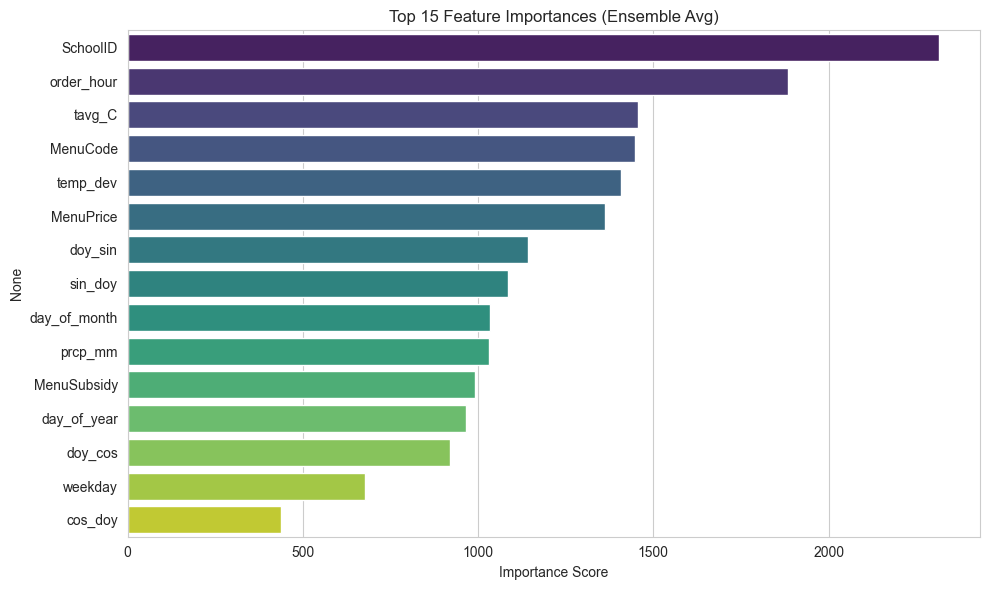

Optimised threshold on inner val: 0.58  (F1=0.833)

Hold out metrics (ensemble):
  Accuracy : 0.699
  Precision: 0.671
  Recall   : 0.739
  F1 score : 0.704
  ROC AUC  : 0.745


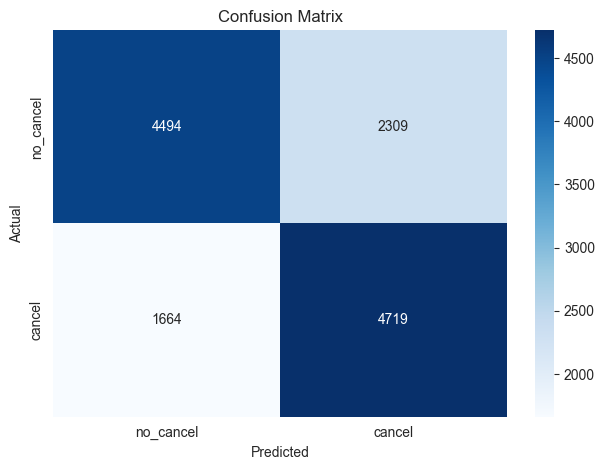

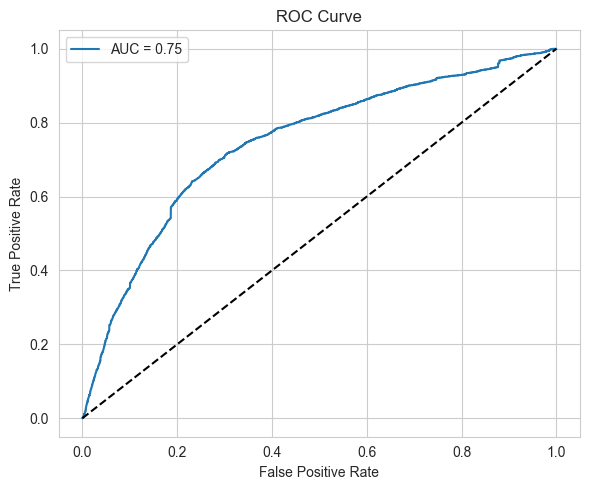

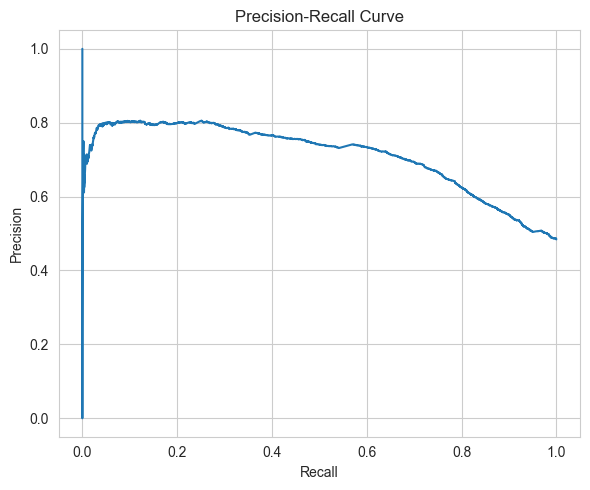

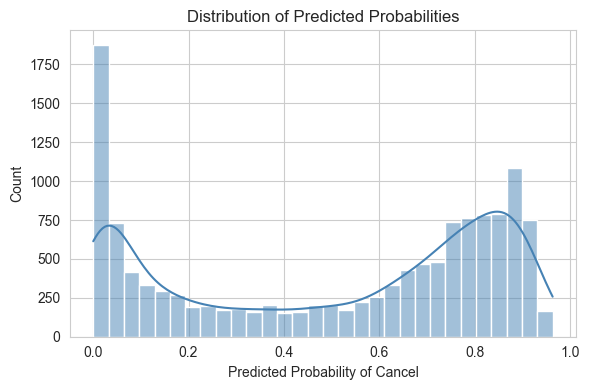

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    f1_score, precision_recall_fscore_support, accuracy_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
)
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

# Load and preprocess
df = pd.read_csv('/Users/shayan/Desktop/IDS2/Stattkueche/poorali/df_weather2_balanced.csv')

drop_cols = [
    'hist_cancel_rate','CanceledQty','net_qty','days_to_cancel',
    'OrderId','TransactionId','BookingNr',
    'MenuName','GroupName','Site','MenuNorm','MenuBase'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

df['DateOfOrder'] = pd.to_datetime(df['DateOfOrder'])
df = df.sort_values('DateOfOrder')
df['month']   = df['DateOfOrder'].dt.month
df['weekday'] = df['DateOfOrder'].dt.weekday
df['hour']    = df['DateOfOrder'].dt.hour
df['doy']     = df['DateOfOrder'].dt.dayofyear
df['doy_sin'] = np.sin(2*np.pi*df['doy']/365)
df['doy_cos'] = np.cos(2*np.pi*df['doy']/365)
df = df.drop(columns=['DateOfOrder','DateOfService','DateOfCancel','doy'])

# Split
cut = int(len(df)*0.85)
train, test = df.iloc[:cut], df.iloc[cut:]

y_train = train['cancel_timing'].map({'cancel':1,'no_cancel':0})
X_train = train.drop(columns='cancel_timing')
y_test  = test['cancel_timing'].map({'cancel':1,'no_cancel':0})
X_test  = test.drop(columns='cancel_timing')

cat_cols = ['SchoolID','MenuCode']
for c in cat_cols:
    X_train[c] = X_train[c].fillna('missing').astype(str)
    X_test[c]  = X_test[c].fillna('missing').astype(str)

looe = LeaveOneOutEncoder(cols=cat_cols, sigma=0.1).fit(X_train, y_train)
X_train_enc = looe.transform(X_train)
X_test_enc  = looe.transform(X_test)

num_cols = X_train_enc.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train_enc[num_cols] = scaler.fit_transform(X_train_enc[num_cols])
X_test_enc[num_cols]  = scaler.transform(X_test_enc[num_cols])

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_enc, y_train, test_size=0.15, stratify=y_train, random_state=RANDOM_STATE
)

cb = CatBoostClassifier(
        depth=6, learning_rate=0.05, l2_leaf_reg=3,
        iterations=1200, random_state=RANDOM_STATE,
        class_weights=[1,2], verbose=False)
lg = LGBMClassifier(
        n_estimators=800, learning_rate=0.05, num_leaves=48,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, min_child_samples=60,
        class_weight={0:1,1:2}, random_state=RANDOM_STATE, verbosity=-1)

cb.fit(X_tr, y_tr);         lg.fit(X_tr, y_tr)

# ---------------- Feature Importance ---------------- #
importances_cb = pd.Series(cb.feature_importances_, index=X_train_enc.columns)
importances_lg = pd.Series(lg.feature_importances_, index=X_train_enc.columns)

ensemble_importance = (importances_cb + importances_lg) / 2
top_feats = ensemble_importance.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_feats.values, y=top_feats.index, palette='viridis')
plt.title('Top 15 Feature Importances (Ensemble Avg)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# ---------------- Threshold tuning ---------------- #
val_prob = 0.5*cb.predict_proba(X_val)[:,1] + 0.5*lg.predict_proba(X_val)[:,1]

best_th, best_f1 = 0.5, 0
for thr in np.linspace(0.2,0.8,31):
    f1 = f1_score(y_val, (val_prob>=thr))
    if f1>best_f1: best_f1, best_th = f1, thr

print(f"Optimised threshold on inner val: {best_th:.2f}  (F1={best_f1:.3f})")

# ---------------- Final prediction on test ---------------- #
test_prob = 0.5*cb.predict_proba(X_test_enc)[:,1] + 0.5*lg.predict_proba(X_test_enc)[:,1]
test_pred = (test_prob >= best_th).astype(int)

acc  = accuracy_score(y_test, test_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, test_pred, average='binary')
auc  = roc_auc_score(y_test, test_prob)

print(f"\nHold out metrics (ensemble):")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1 score : {f1:.3f}")
print(f"  ROC AUC  : {auc:.3f}")

# ---------------- Confusion Matrix ---------------- #
cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['no_cancel','cancel'],
            yticklabels=['no_cancel','cancel'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix'); plt.tight_layout(); plt.show()

# ---------------- ROC Curve ---------------- #
fpr, tpr, _ = roc_curve(y_test, test_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------- Precision-Recall Curve ---------------- #
prec_curve, rec_curve, _ = precision_recall_curve(y_test, test_prob)
plt.figure(figsize=(6,5))
plt.plot(rec_curve, prec_curve)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------- Distribution of predicted probabilities ---------------- #
plt.figure(figsize=(6,4))
sns.histplot(test_prob, bins=30, kde=True, color='steelblue')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability of Cancel')
plt.tight_layout()
plt.show()
